In [1]:
import xarray as xr
from dask.diagnostics import ProgressBar
from dask.distributed import Client
xr.set_options(keep_attrs=True)
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import numpy as np
from utils import beaker_to_xarray

In [2]:
Client()

<Client: 'tcp://127.0.0.1:34701' processes=4 threads=8, memory=29.37 GiB>

In [3]:
beaker_dataset_id = '01JAPMH88KKYHM27WX0AVKDCPX'
era5_url = 'gs://vcm-ml-intermediate/2024-06-20-era5-1deg-8layer-1940-2022.zarr'
start_year = '1990'
end_year = '2019'

In [4]:
ds_era5 = xr.open_zarr(era5_url)
ds_era5['PRATEsfc'] = (86400 * ds_era5['PRATEsfc']).assign_attrs(units='mm/day')

In [5]:
variables = ['TMP2m', 'PRATEsfc', 'ULWRFtoa', 'USWRFtoa', 'UGRD10m', 'eastward_wind_3', 'air_temperature_0', 'specific_total_water_0', ]

In [6]:
with ProgressBar():
    ds_era5_mean = ds_era5[variables].sel(time=slice(start_year, end_year)).mean(dim='time').compute()

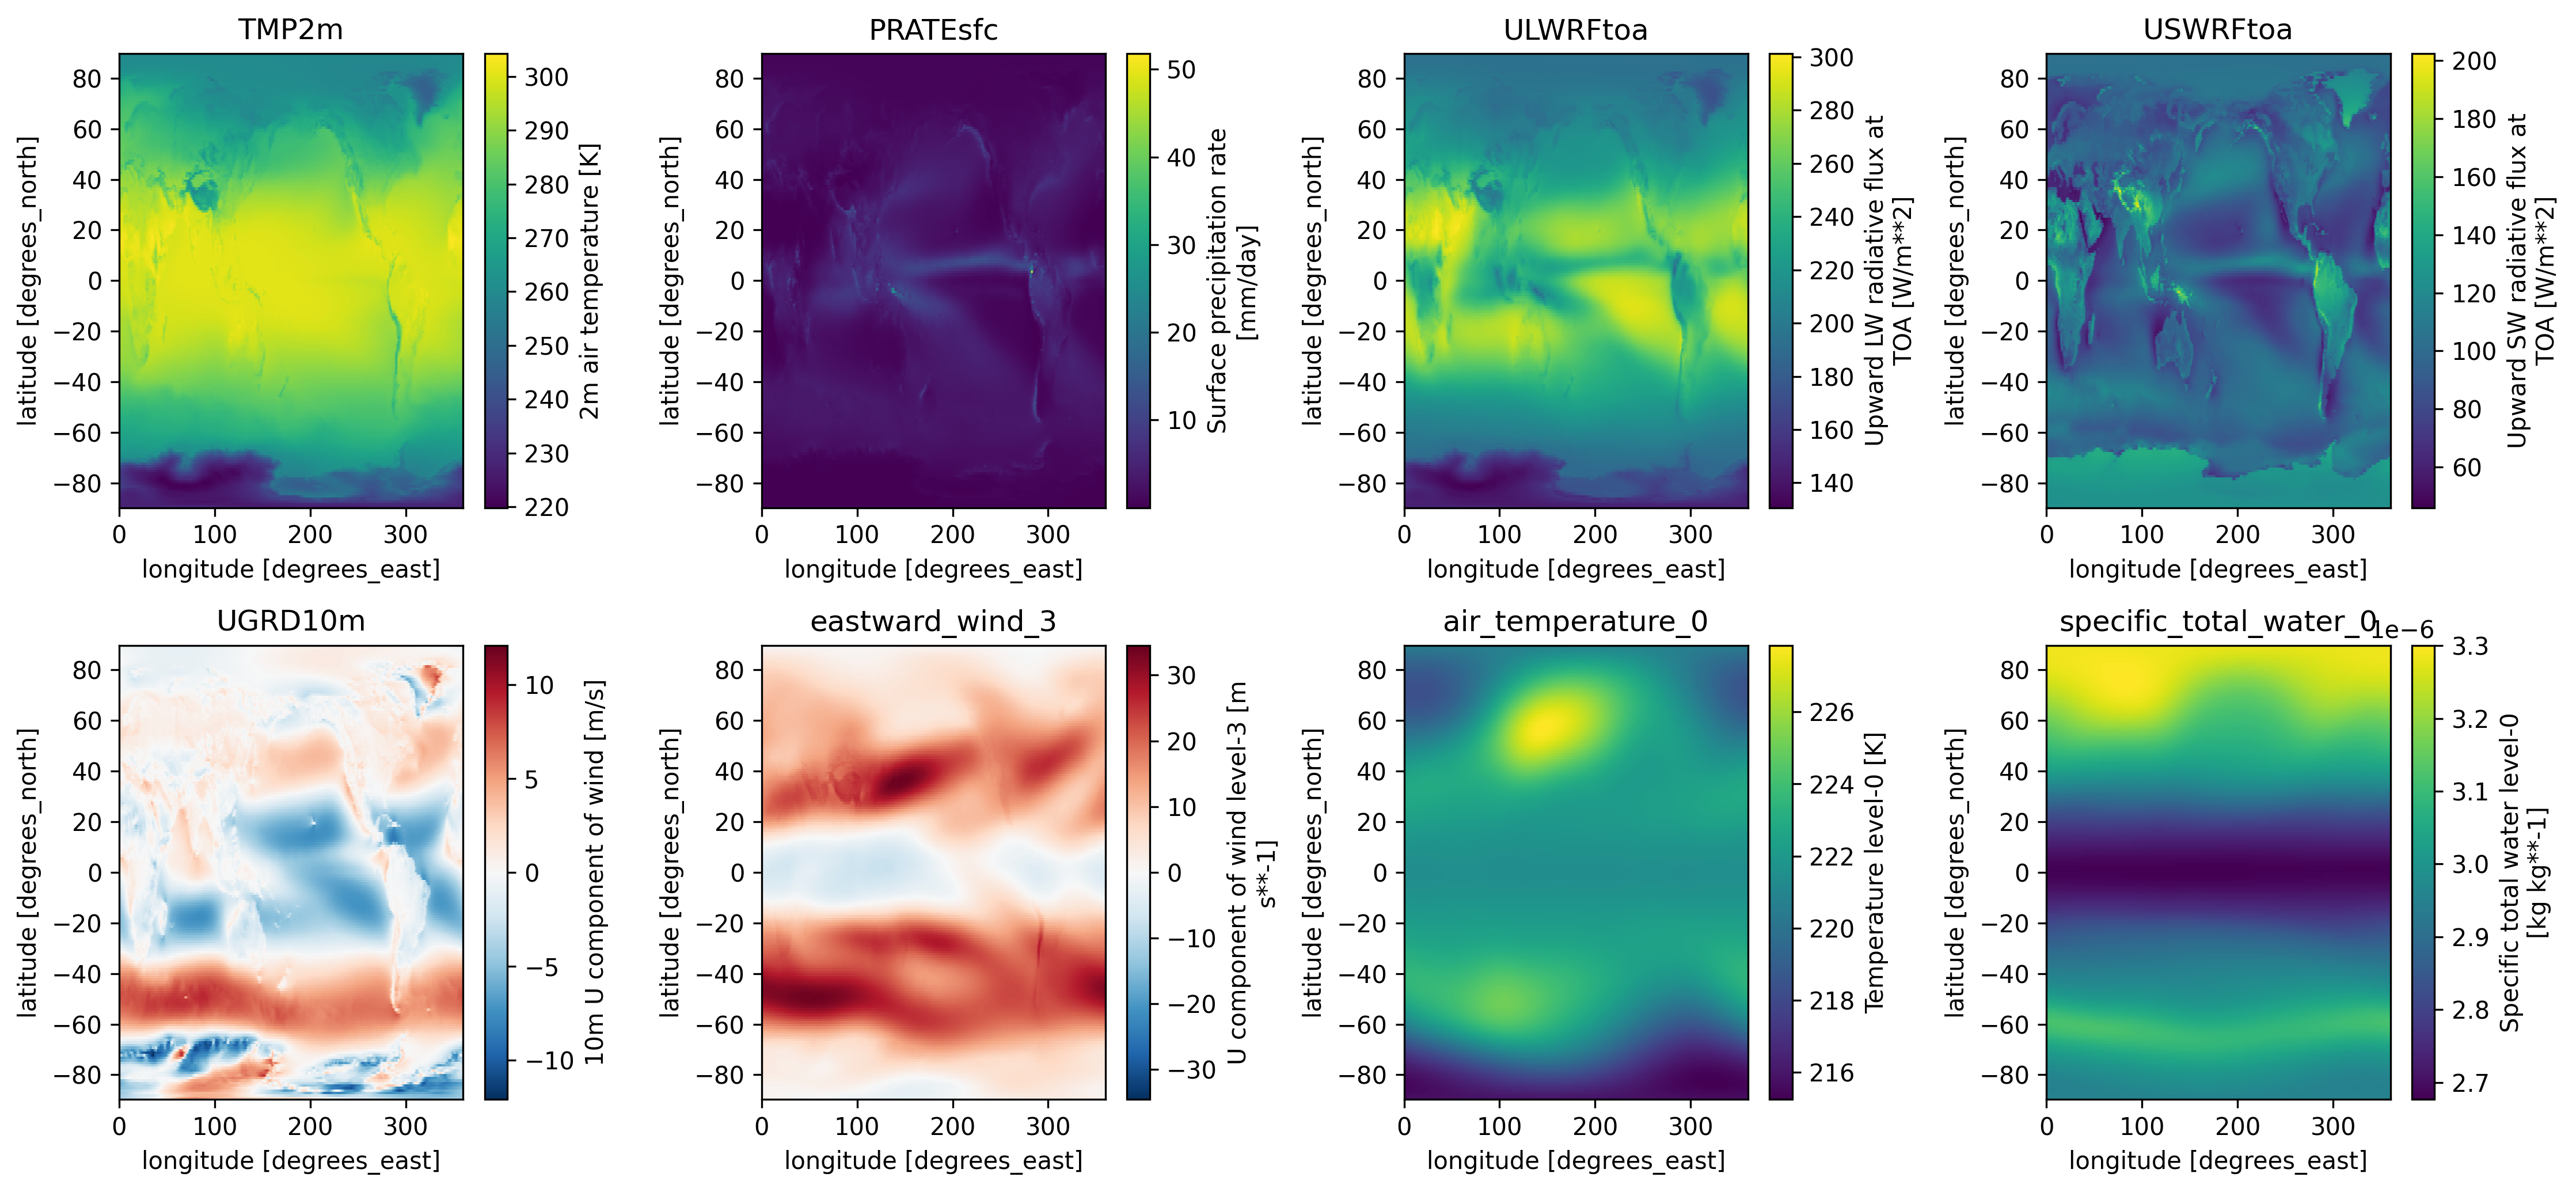

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7))
axes = axes.flat
for i, var in enumerate(variables):
    ds_era5_mean[var].plot(ax=axes[i])
    axes[i].set_title(var)
fig.tight_layout()

### Load time-mean from each segment

In [8]:

rename = {f"gen_map-{var}": var for var in variables}
coord_rename = {'lat': 'latitude', 'lon': 'longitude'}

def get_time_mean(beaker_dataset_id, segment_number, latitude):
    ds = beaker_to_xarray(beaker_dataset_id, f"segment_{segment_number:04}/time_mean_diagnostics.nc")
    ds = ds.rename(rename)
    ds = ds.rename(coord_rename)
    ds = ds[variables]
    ds['latitude'] = latitude
    ds['PRATEsfc'] = (86400 * ds['PRATEsfc']).assign_attrs(units='mm/day')
    return ds

In [9]:
ds_ace2 = []
for segment_number in range(10):
    ds = get_time_mean(beaker_dataset_id, segment_number, ds_era5.latitude)
    ds = ds.assign_coords(segment=segment_number)
    ds_ace2.append(ds)

ds_ace2 = xr.concat(ds_ace2, dim='segment')

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

### Load monthly-mean data

In [10]:
#rename = {f"gen_map-{var}": var for var in variables}
coord_rename = {'lat': 'latitude', 'lon': 'longitude'}

def get_monthly(beaker_dataset_id, segment_number, latitude):
    ds = beaker_to_xarray(beaker_dataset_id, f"segment_{segment_number:04}/monthly_mean_predictions.nc")
    ds = ds.rename(coord_rename)
    ds = ds.isel(sample=0).isel(time=slice(None, -2))  # weird empty two months at the end
    ds['time'] = ds.valid_time  # more useful time coordinate, can use since only have one ensemble member
    ds['latitude'] = latitude
    return ds

In [11]:
ds_ace2_monthly_segment_0 = get_monthly(beaker_dataset_id, 0, ds_era5.latitude)
ds_ace2_monthly_segment_9 = get_monthly(beaker_dataset_id, 9, ds_era5.latitude)

Output()

Output()

/home/OliWM/repos/ace2-paper/notebooks/utils.py:61: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  return xr.open_dataset(io.BytesIO(file), engine='h5netcdf').load()
/home/OliWM/repos/ace2-paper/notebooks/utils.py:61: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  return xr.open_dataset(io.BytesIO(file), engine='h5netcdf').load()
/home/OliWM/repos/ace2-paper/notebooks/utils.py:61: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning

In [12]:
weights = np.cos(np.deg2rad(ds_ace2_monthly_segment_0.latitude))
segment_0_gm = ds_ace2_monthly_segment_0.total_water_path.weighted(weights).mean(dim=['latitude', 'longitude'])
segment_9_gm = ds_ace2_monthly_segment_9.total_water_path.weighted(weights).mean(dim=['latitude', 'longitude'])

In [13]:
segment_0_gm['time'] = np.arange(0, len(segment_0_gm.time) / 12, 1 / 12)
segment_9_gm['time'] = segment_0_gm['time'] + 900
segment_0_gm['time'].attrs['units'] = 'years since init'
segment_9_gm['time'].attrs['units'] = 'years since init'

In [14]:
segment_0_gm_am = segment_0_gm.rolling(time=12, center=True).mean()
segment_9_gm_am = segment_9_gm.rolling(time=12, center=True).mean()

In [15]:
monthly_mean = xr.concat([segment_0_gm, segment_9_gm], dim='time')
annual_mean = xr.concat([segment_0_gm_am, segment_9_gm_am], dim='time')

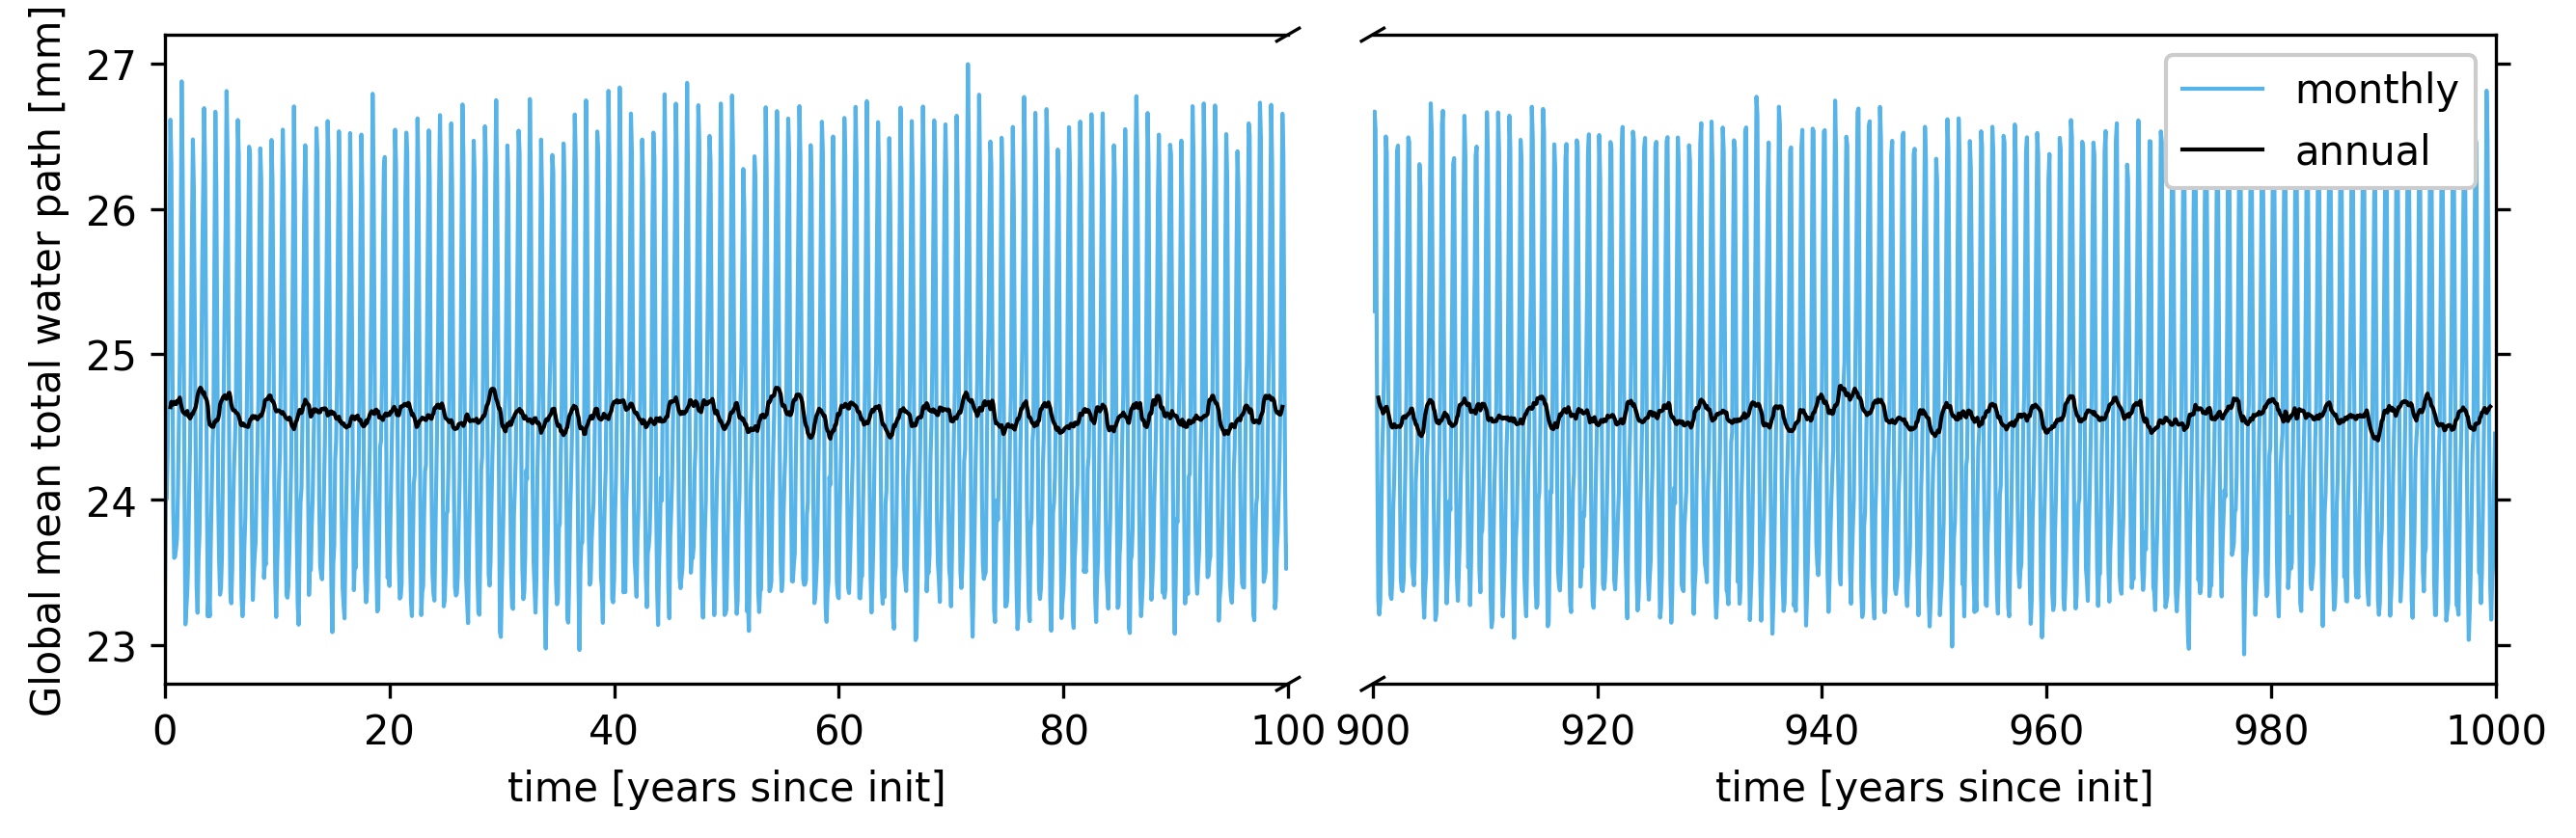

In [16]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9, 3))
monthly_mean[:1200].plot(ax=ax[0], linewidth=1, label='monthly')
monthly_mean[1200:].plot(ax=ax[1], linewidth=1, label='monthly')
annual_mean.plot(ax=ax[0], linewidth=1, color='black', label='annual')
annual_mean.plot(ax=ax[1], linewidth=1, color='black', label='annual')
ax[1].legend(loc='upper right', framealpha=1)
ax[0].set_ylabel('Global mean total water path [mm]')
ax[0].set_title('')
ax[0].set_xlim([0, 100])
ax[1].set_xlim([900, 1000])
ax[1].set_title('')
ax[1].set_ylabel('')
ax[1].yaxis.tick_right()
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)

# make nice break lines. From https://stackoverflow.com/questions/32185411/break-in-x-axis-of-matplotlib
d = .01  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False, linewidth=0.8)
ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax[1].transAxes)  # switch to the bottom axes
ax[1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)
ax[0].set_facecolor('white')
ax[1].set_facecolor('white')
fig.patch.set_alpha(0.0)

fig.tight_layout(w_pad=0.2)
fig.savefig('figures/era5_1000yr_twp_timesries.png', transparent=True, dpi=300, bbox_inches='tight')

### Plot time-average maps across different segments

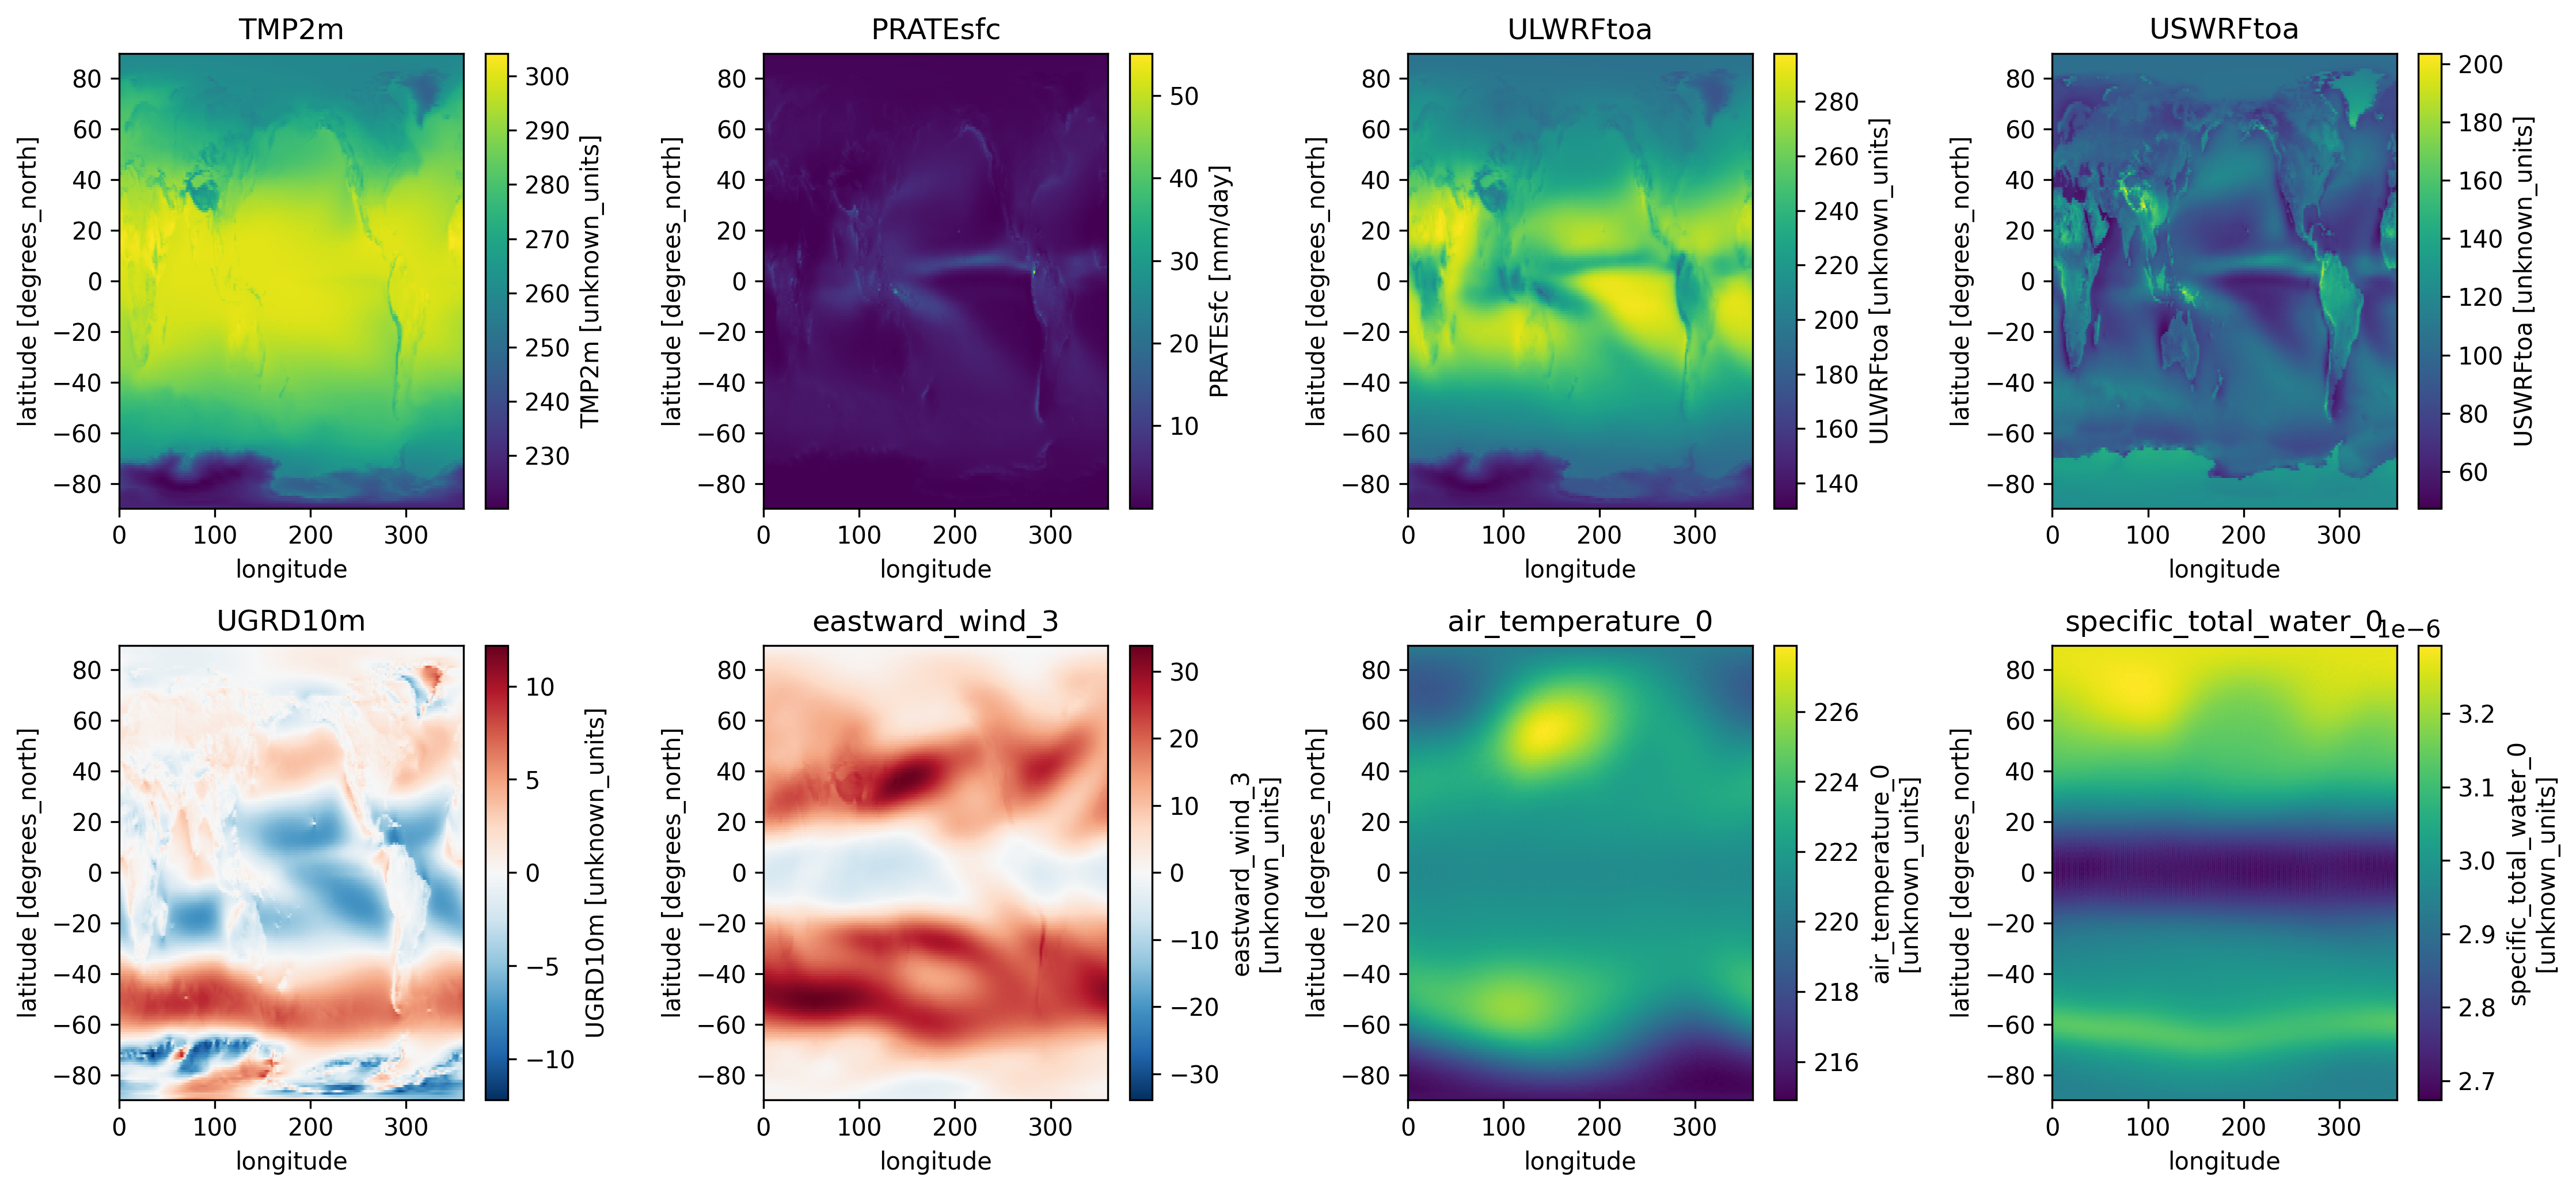

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7))
axes = axes.flat
for i, var in enumerate(variables):
    ds_ace2.isel(segment=0)[var].plot(ax=axes[i])
    axes[i].set_title(var)
fig.tight_layout()

In [18]:
ds_ace2_bias = ds_ace2 - ds_era5_mean
for name in ds_ace2_bias:
    ds_ace2_bias[name].attrs = ds_era5_mean[name].attrs

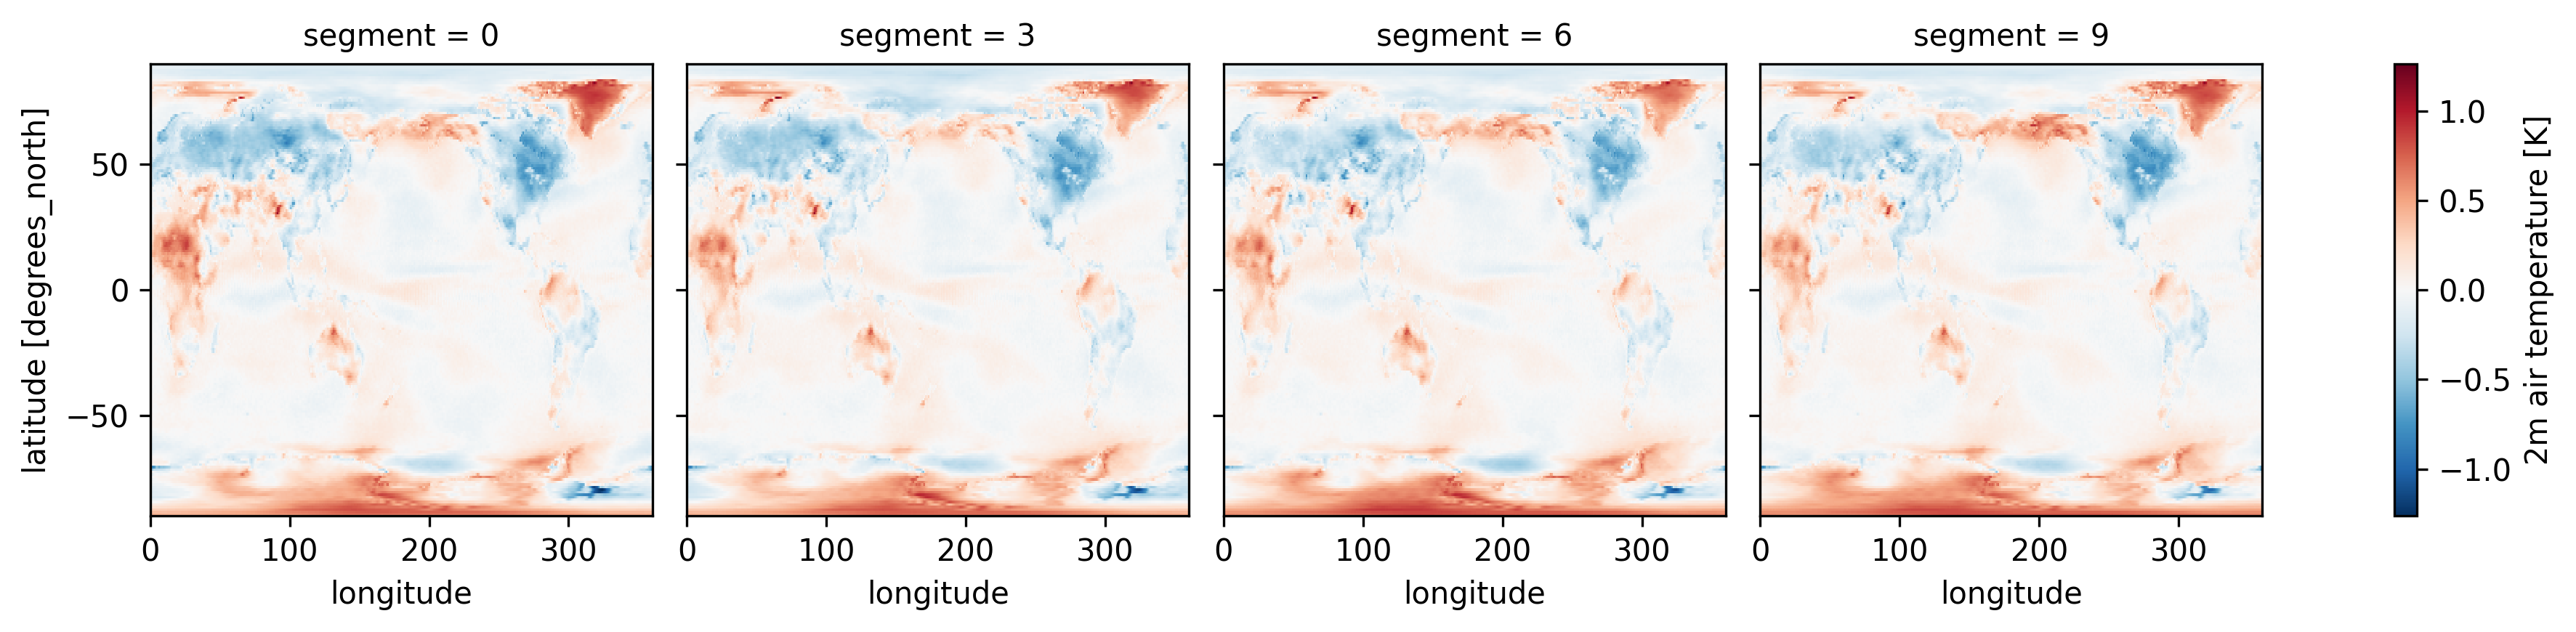

In [19]:
ds_ace2_bias.TMP2m.isel(segment=[0, 3, 6, 9]).plot(col='segment')

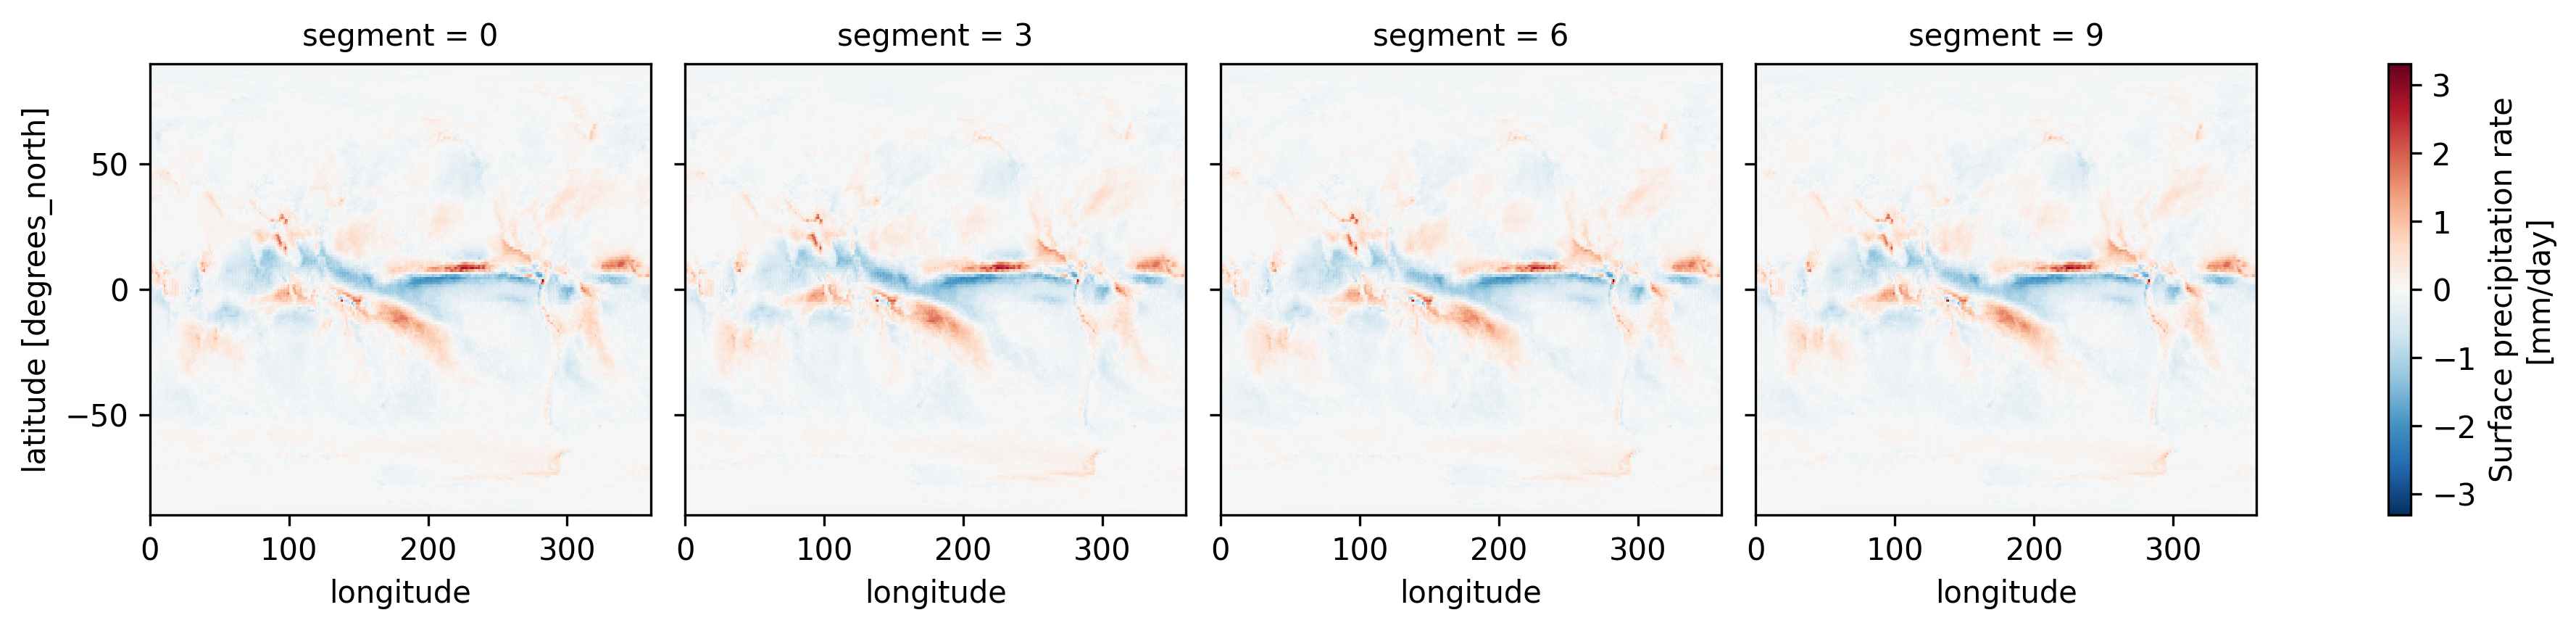

In [20]:
ds_ace2_bias.PRATEsfc.isel(segment=[0, 3, 6, 9]).plot(col='segment')

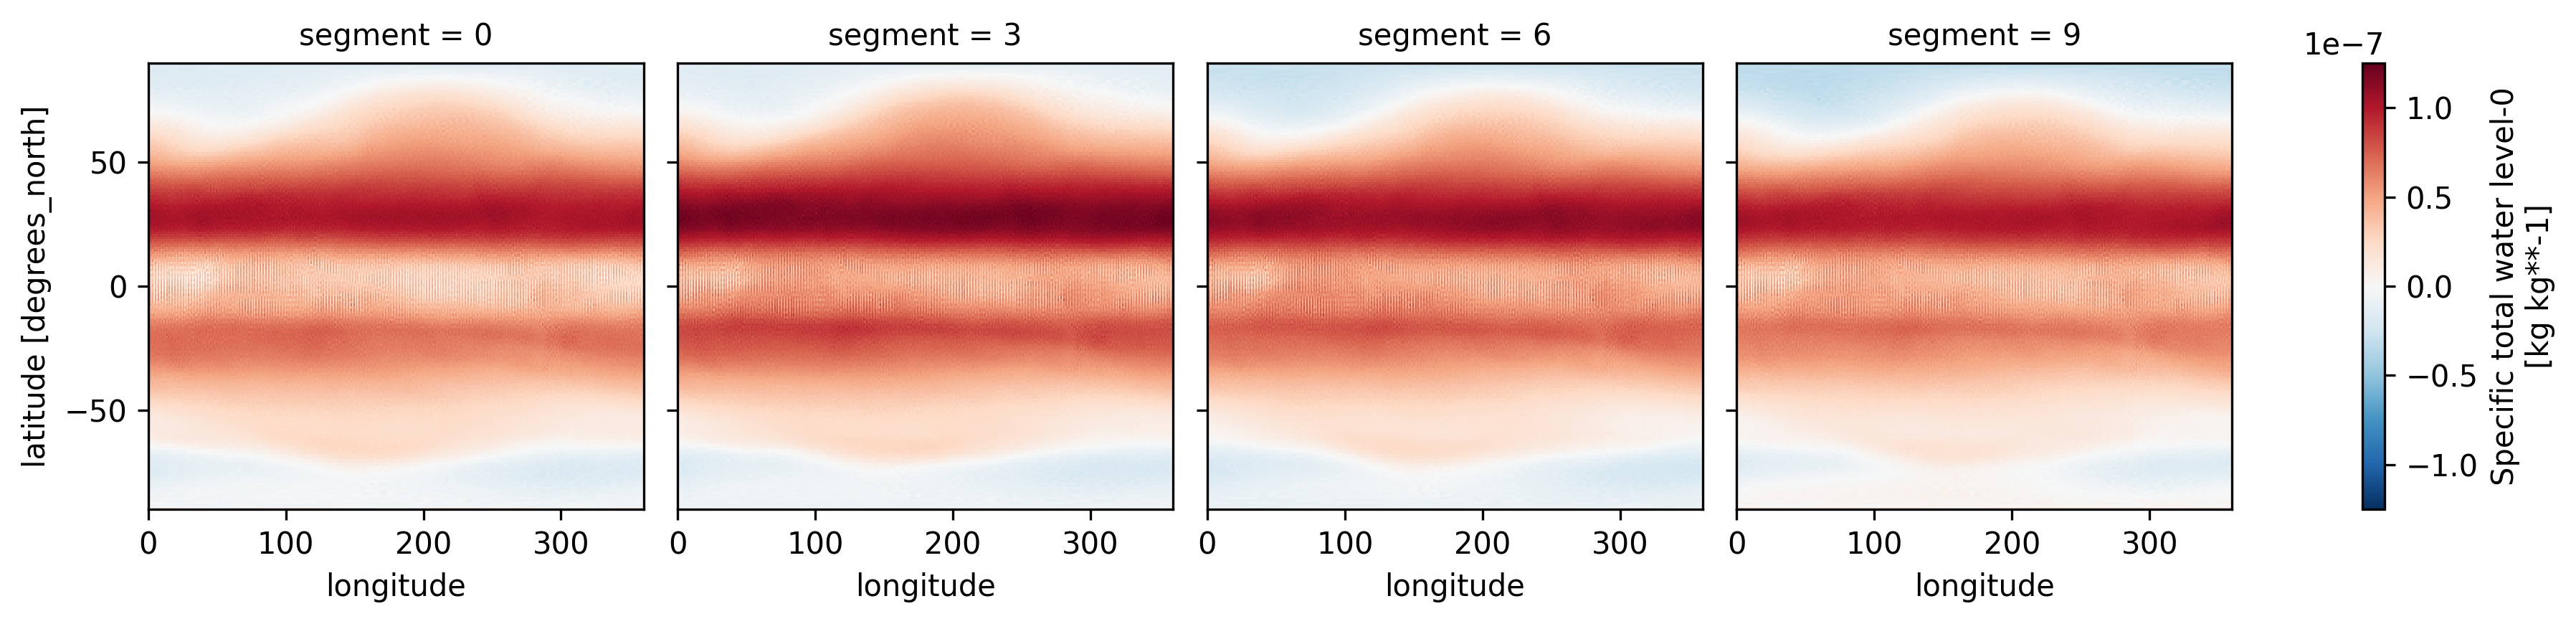

In [21]:
ds_ace2_bias.specific_total_water_0.isel(segment=[0, 3, 6, 9]).plot(col='segment')

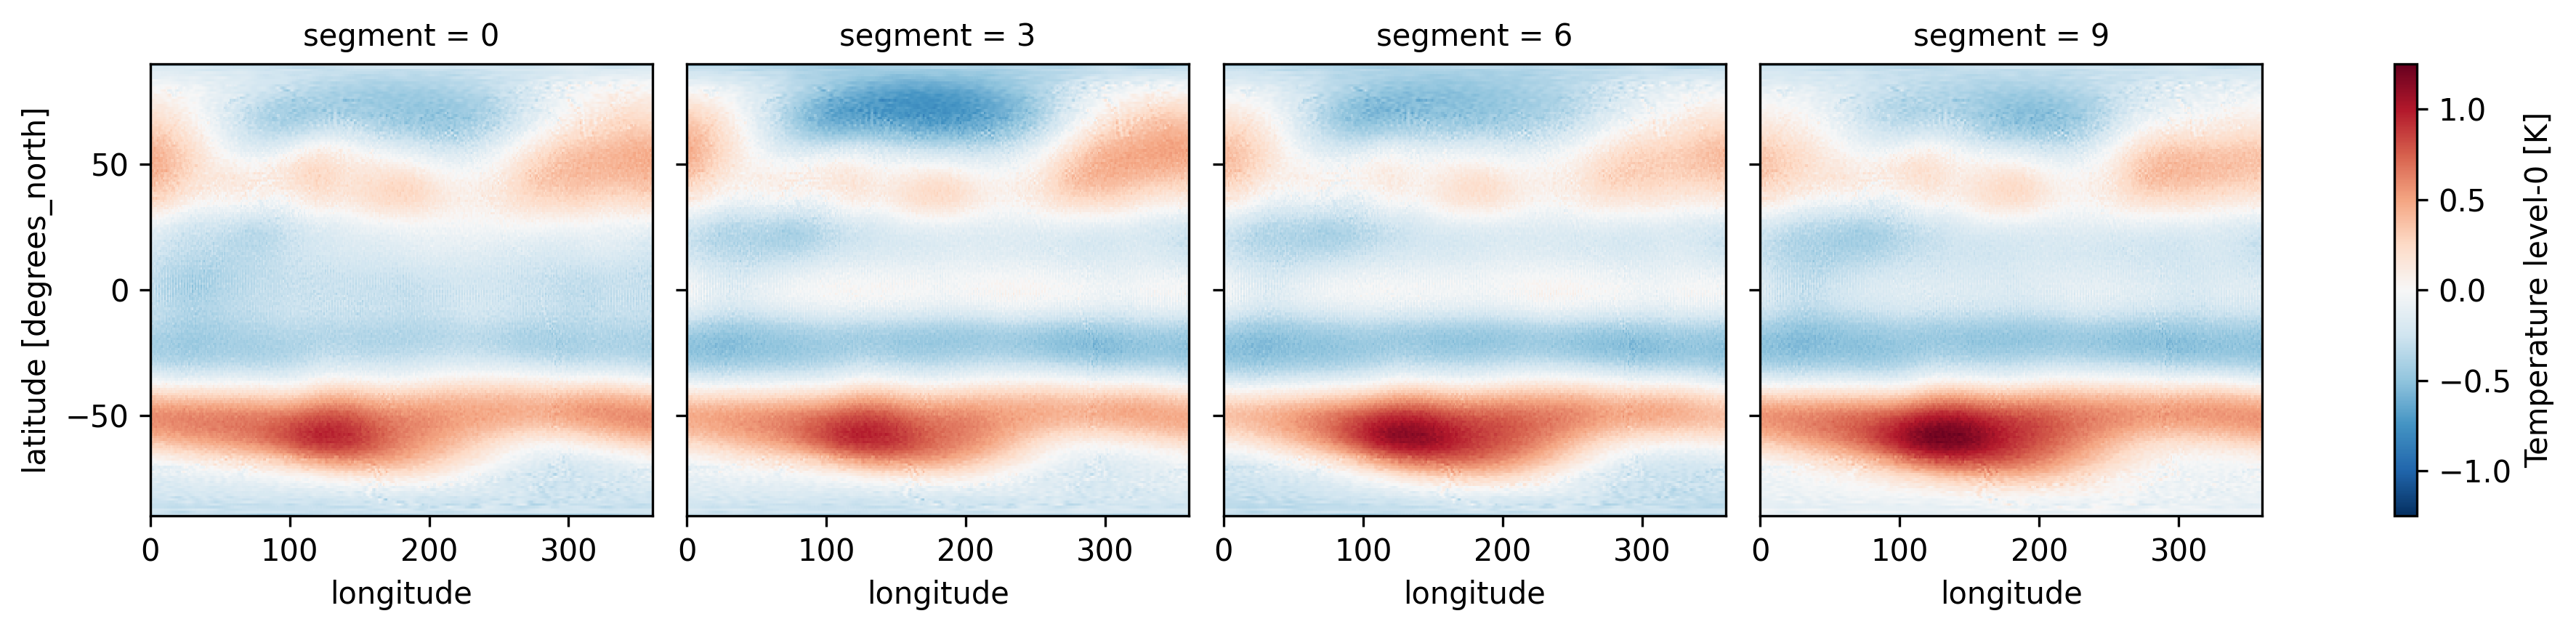

In [22]:
ds_ace2_bias.air_temperature_0.isel(segment=[0, 3, 6, 9]).plot(col='segment')